In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table, Column

%matplotlib inline

In [69]:
cat_file='data/Nearby galaxy groups - Fouque 1992.txt'
cat_data=Table(dtype=[('name', 'S30'), ('ra', 'f4'), ('dec', 'f4'), ('l','f4'), ('b','f4'), ('N','i4'), ('velocity','f4'),('distance','f4'),('members','S300')])

file = open(cat_file, 'r')

id=0
for line in file:
    if line[0]=='#': continue
    elif line[0]!=' ':
        word=line.split()
#        print word
        if word[1].isdigit():
            data=tuple((word[0],(float(word[1])+float(word[2])/60.)*360/24,word[3],word[4],word[5],word[6],word[7],word[8],word[9]))
        elif word[2].isdigit():
            data=tuple((word[0]+' '+word[1],(float(word[2])+float(word[3])/60.)*360/24,word[4],word[5],word[6],word[7],word[8],word[9],word[10]))
        elif word[3].isdigit():
            data=tuple((word[0]+' '+word[1]+' '+word[2],(float(word[3])+float(word[4])/60.)*360/24,word[5],word[6],word[7],word[8],word[9],word[10],word[11]))
        else:
            print 'WARNING: Something is wrong'
        cat_data.add_row(data)
        id=id+1
    elif line[0]==' ':
        word=line.split()
#        print word
        cat_data['members'][-1]=cat_data['members'][-1]+word[0]

cat_data.write('data/Nearby galaxy groups - Fouque 1992.csv', format='csv')
cat_data
#cat_data=cat_data.to_pandas()
#cat_data.to_json('data/Nearby galaxy groups - Fouque 1992.json',orient='records')
#cat_data.head()

name,ra,dec,l,b,N,velocity,distance,members
str30,float32,float32,float32,float32,int32,float32,float32,str300
M81,152.5,69.1,42.0,2.0,11,127.0,12.0,"2976,3031,3034,3077,4236,IC2574,UGC5139,UGC5247,UGC5336,UGC5692,UGC8201."
Maffei,57.25,68.0,11.0,0.0,5,171.0,10.0,"1560,1569,IC342,UGCA92,UGCA105."
Sculptor,9.0,-31.0,265.0,-4.0,8,177.0,9.0,"55,247,253,300,7793,IC1574,ESO471-6,ESO540-31."
NGC2403,115.75,66.7,31.0,-7.0,3,231.0,12.0,"2366,2403,UGC4305."
Canes I,184.5,35.8,80.0,2.0,10,294.0,13.0,"4150,4163,4190,4214,4244,4395,UGC6817,UGC7559,UGC7599,UGC7698."
M101,210.75,54.6,63.0,23.0,7,363.0,25.0,"5204,5457,5474,5585,UGC8508,UGC8837,UGC9405."
NGC5128,201.25,-41.6,158.0,-5.0,15,390.0,14.0,"4945,5102,5128,5206,5236,5237,5253,5264,5408,ESO270-17,ESO324-24,ESO325-11,ESO381-20,ESO383-87,PGC51659."
NGC672,27.75,27.8,327.0,-5.0,3,458.0,20.0,"672,784,IC1727."
NGC5194,197.25,44.0,74.0,13.0,17,466.0,25.0,"4449,4736,5023,5055,5194,5195,5229,5238,IC3687,IC4182,IC4263,UGC7577,UGC7949,UGC8313,UGC8320,UGC8331,UGC8651."


In [70]:
cat_file='data/Nearby galaxy groups - Fouque 1992.csv'
cat_data=Table.read(cat_file, format='csv')
cat_data

gv=((cat_data['dec']<15.) & (cat_data['distance']<20.*3.2) & (cat_data['N']>4))
cat_data[gv]
#pd.read_json(cat_file, orient='records')
#cat_data.keys()
#cat_data.head()

name,ra,dec,l,b,N,velocity,distance,members
str12,float64,float64,float64,float64,int64,float64,float64,str300
Sculptor,9.0,-31.0,265.0,-4.0,8,177.0,9.0,"55,247,253,300,7793,IC1574,ESO471-6,ESO540-31."
NGC5128,201.25,-41.5999984741,158.0,-5.0,15,390.0,14.0,"4945,5102,5128,5206,5236,5237,5253,5264,5408,ESO270-17,ESO324-24,ESO325-11,ESO381-20,ESO383-87,PGC51659."
Leo I,165.5,13.0,95.0,-23.0,14,702.0,35.0,"3299,3351,3368,3377,3377A,3379,3384,3412,3489,3593,3599,3623,3627,3628."
NGC6744,286.0,-64.1999969482,207.0,10.0,6,746.0,40.0,"6684,6684A,6744,IC4710,IC4824,ESO141-42."
NGC2427,116.0,-50.0,193.0,-54.0,5,823.0,40.0,"2427,2502,ESO208-21,ESO208-33,ESO209-9."
NGC2997,146.25,-31.1000003815,146.0,-48.0,8,851.0,40.0,"2997,3056,IC2507,ESO373-8,ESO434-33,ESO434-34,ESO434-41,ESO435-16."
Virgo I,188.0,11.5,104.0,-2.0,177,895.0,52.0,"4037,4064,4124,4178,4192,4204,4206,4212,4216,4222,4237,4239,4262,4267,4293,4294,4298,4299,4302,4305,4307,4309,4312,4313,4316,4321,4330,4336,4339,4340,4341,4343,4350,4352,4356,4365,4371,4374,4377,4379,4380,4382,4383,4387,4394,4396,4402,4406,4411A,4411B,4413,4416,4417,4419,4421,4423,4424,4425,4429,443"
NGC1433,57.75,-46.2999992371,248.0,-41.0,10,916.0,60.0,"1411,1433,1448,1493,1494,1495,1527,IC1970,IC2000,ESO249-36."
NGC4594,190.0,-11.1000003815,126.0,-7.0,8,957.0,50.0,"4487,4504,4594,4722,4802,MCG-1-32-28,MCG-2-32-15,MCG-2-33-47."


In [91]:
def plot_mwd(ra,dec,org=0,title='Mollweide projection', projection='mollweide'):
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    ax.scatter(np.radians(x),np.radians(dec), marker='o', s=30, facecolor='red', edgecolor='', alpha=0.5)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

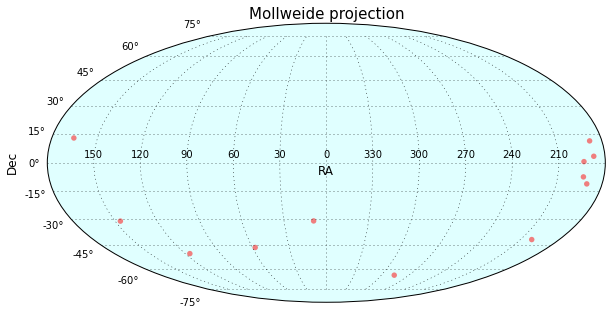

In [92]:
plot_mwd(cat_data['ra'][gv],cat_data['dec'][gv])